# Data Challenge 3: Understanding Employee Churn

## Susan Currie Sivek

This client sought a deeper understanding of factors affecting employee churn at a set of companies. Given that churn is costly and destabilizing to a company, finding out when and why it occurs could suggest useful changes to HR and other management practices.

This dataset included over 34K records on employees from various companies gathered from 1/24/11 to 12/13/2015. However, 10K of those records belonged to temporary contractors. Since employee churn is the main focus here, I focused my analysis on "permanent," long-term employees.

### Key Takeaways:
- Seniority (experience at hiring) and salary are not strongly correlated to an employee's duration of employment.
- The employee's specific corporate department does not appear to be strongly related either.
- Employees hired earlier among those included in these data had a greater likelihood of making it to 2+ years of employment. This difference could be explained by specific company practices, management changes, or even broader economic conditions.

## Data Cleaning

First I'll import the data and get it ready for analysis.

In [11]:
# import necessary tools

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv("/Users/ssivek/Insight_Projects/data_c/Week 7/employee_retention.csv")

In [4]:
# delete unnamed, employee ID columns; unnecessary
df = df.drop(['Unnamed: 0'], axis=1) 
df = df.drop(['employee_id'], axis=1)

In [5]:
# standardize date styles in join_date column
dot_dates = df[df['join_date'].str.contains("\.")]
hyp_dates = df[df['join_date'].str.contains("-")]

In [6]:
# make cleaned columns and concat back together; drop old messy join_date column
dot_dates['join_date_clean'] = pd.to_datetime(dot_dates['join_date'], format='%m.%d.%Y', errors='coerce')
hyp_dates['join_date_clean'] = pd.to_datetime(hyp_dates['join_date'], format='%Y-%m-%d', errors='coerce')

/Users/ssivek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ssivek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
new_dates = pd.concat([dot_dates, hyp_dates], axis=0, verify_integrity=True)

In [9]:
# need to also get quit date into datetime format
new_dates['quit_date_clean'] = pd.to_datetime(new_dates['quit_date'], format='%Y-%m-%d', errors='coerce')

In [10]:
# remove old date columns for clarity
new_dates = new_dates.drop(['join_date', 'quit_date'], axis=1)

In [12]:
# make feature for employment duration for those currently employed as of dataset date, 2015/12/13 
d = datetime.date(2015, 12, 13)
print(d)

2015-12-13


In [21]:
new_dates['data_end_date'] = d

In [22]:
new_dates['data_end_date'] = pd.to_datetime(new_dates['data_end_date'], format='%Y-%m-%d', errors='coerce')

In [23]:
new_dates['emp_duration'] = ''

In [33]:
# add employment duration column
new_dates.loc[new_dates['emp_duration'].isnull(),'emp_duration'] = (new_dates['quit_date_clean'] - new_dates['join_date_clean']).dt.days.div(365.25).round(4)

In [34]:
new_dates.head() 

,company_id,dept,seniority,salary,join_date_clean,quit_date_clean,data_end_date,emp_duration
1,8,design,21,191000.0,2011-05-17,2012-03-16,2015-12-13,0.8323
7,7,data_science,7,140000.0,2011-12-27,2013-08-30,2015-12-13,1.6756
8,10,data_science,16,238000.0,2013-12-23,NaT,2015-12-13,1.9713
23,1,sales,19,179000.0,2011-09-19,2012-11-02,2015-12-13,1.1225
34,2,engineer,19,309000.0,2012-01-17,NaT,2015-12-13,3.9042


In [35]:
new_dates.info() # missing data (239 employees) in salary column, and also in quit_date column (11192 employees)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34702 entries, 1 to 34701
Data columns (total 8 columns):
company_id         34702 non-null int64
dept               34702 non-null object
seniority          34702 non-null int64
salary             34463 non-null float64
join_date_clean    34702 non-null datetime64[ns]
quit_date_clean    23510 non-null datetime64[ns]
data_end_date      34702 non-null datetime64[ns]
emp_duration       34702 non-null object
dtypes: datetime64[ns](3), float64(1), int64(2), object(2)
memory usage: 3.6+ MB


In [36]:
df = new_dates # easier name

I'm going to take a closer look at the rows that are missing salary and quit date to see if there are any important patterns. Then I can decide how to handle the missing information.

In [37]:
missing_salary = df[df.salary.isnull()]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a200885c0>,
      dtype=object)

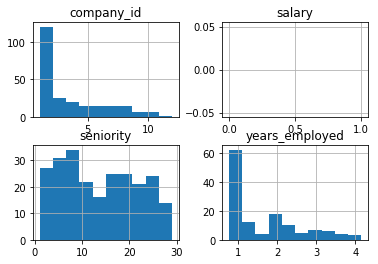

In [92]:
missing_salary.hist()

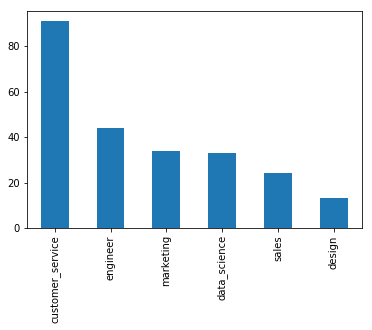

In [39]:
missing_salary.dept.value_counts().plot(kind='bar')

In [40]:
corr = missing_salary.corr()
corr.style.background_gradient(cmap='coolwarm')

/Users/ssivek/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,company_id,seniority,salary
company_id,1,0.00783054,nan
seniority,0.00783054,1,nan
salary,nan,nan,nan


The missing salary information seems to be scattered across the companies, salaries, departments, and seniority levels, with no discernible pattern. I haven't checked for any pattern by date, though. Let's check out quit dates more closely. Maybe this information wasn't recorded for people at a particular time.

In [41]:
missing_quit = df[df.quit_date_clean.isnull()]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1804e198>,
      dtype=object)

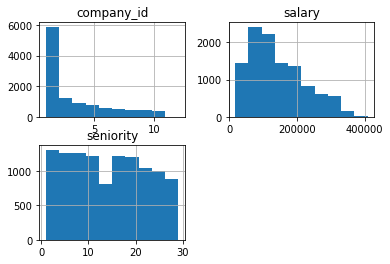

In [42]:
missing_quit.hist()

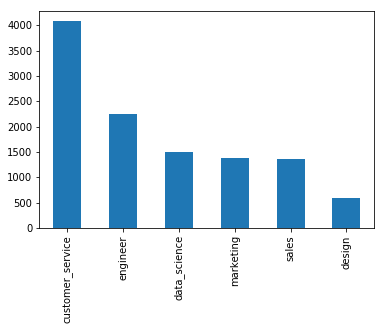

In [43]:
missing_quit.dept.value_counts().plot(kind='bar')

Once again, the missing quit date information looks to be scattered across the companies, departments, and seniority levels, with no discernible pattern. 

Salary is missing in only a small number of rows (<1% of my dataset). The missing quit dates may represent employees still employed. But there's one more thing to check: is the data missing for employees with any specific start date?

In [44]:
missing_salary['join_date_clean'].value_counts() # no pattern visible here

2013-01-14    5
2015-01-20    5
2014-06-16    4
2015-07-27    4
2012-09-10    4
2011-11-07    4
2014-03-31    3
2012-12-11    3
2011-06-13    3
2015-08-24    3
2015-09-21    3
2012-03-12    3
2013-10-14    3
2013-04-08    3
2012-01-03    2
2014-01-21    2
2012-10-08    2
2014-08-18    2
2015-04-13    2
2015-03-16    2
2013-01-07    2
2011-06-20    2
2011-10-31    2
2014-12-29    2
2012-09-24    2
2015-03-09    2
2014-11-24    2
2011-06-27    2
2011-03-21    2
2014-01-27    2
             ..
2012-12-10    1
2011-10-18    1
2014-04-15    1
2015-01-12    1
2014-06-30    1
2015-10-19    1
2012-01-12    1
2014-09-02    1
2014-01-15    1
2012-05-15    1
2011-04-25    1
2013-09-30    1
2013-10-28    1
2014-08-04    1
2015-01-13    1
2011-05-24    1
2015-10-26    1
2012-07-24    1
2013-10-15    1
2013-05-06    1
2015-02-09    1
2015-10-12    1
2014-07-07    1
2013-07-31    1
2014-03-12    1
2015-08-04    1
2013-12-02    1
2012-10-29    1
2012-01-23    1
2014-10-06    1
Name: join_date_clean, L

In [45]:
missing_quit['join_date_clean'].value_counts() 
# no pattern visible here either, except that, naturally, 
# more new hires are missing quit dates because they're still employed

2015-07-06    93
2015-06-08    92
2015-03-16    91
2015-03-09    90
2015-10-19    89
2015-01-20    89
2015-02-09    89
2015-09-14    88
2015-09-21    88
2015-02-17    88
2015-08-03    87
2015-08-10    87
2015-03-23    87
2015-10-05    86
2015-11-30    86
2015-05-26    86
2015-11-16    86
2015-10-26    85
2015-07-27    85
2015-06-22    84
2015-04-13    84
2015-05-11    84
2015-10-12    84
2015-01-26    83
2015-11-23    83
2015-07-13    81
2015-05-18    80
2015-08-31    80
2015-06-01    79
2015-11-02    79
              ..
2013-04-10     1
2014-11-06     1
2013-09-24     1
2013-04-02     1
2012-02-28     1
2012-07-03     1
2012-08-29     1
2013-04-16     1
2011-12-14     1
2014-05-22     1
2012-10-03     1
2011-02-14     1
2013-07-18     1
2013-07-24     1
2012-11-07     1
2012-02-22     1
2015-02-06     1
2014-08-01     1
2012-09-13     1
2012-08-07     1
2013-11-07     1
2012-11-20     1
2012-01-05     1
2011-06-21     1
2013-01-16     1
2013-06-06     1
2014-08-14     1
2012-09-06    

## Wrapping Up Data Prep and Adding Features

Since I don't see any patterns in where/how the salary and quit date data are missing, I'm going to:

- delete the rows with missing salary information, since there are so few of them and the effect should be negligible
- assume that the rows with missing quit dates do actually belong to employees still employed by the company

In [46]:
# delete rows with missing salary information

df = df.dropna(subset=['salary'])

In [48]:
df = df.drop(['data_end_date'], axis=1) # don't need this now

In [49]:
df.head()

,company_id,dept,seniority,salary,join_date_clean,quit_date_clean,emp_duration
1,8,design,21,191000.0,2011-05-17,2012-03-16,0.8323
7,7,data_science,7,140000.0,2011-12-27,2013-08-30,1.6756
8,10,data_science,16,238000.0,2013-12-23,NaT,1.9713
23,1,sales,19,179000.0,2011-09-19,2012-11-02,1.1225
34,2,engineer,19,309000.0,2012-01-17,NaT,3.9042


In [57]:
df.emp_duration = df.emp_duration.astype(float)

In [60]:
df.to_csv("/Users/ssivek/Insight_Projects/data_c/Week 7/employee_retention_clean.csv") # keep a clean copy

In [61]:
work = df

## Temporary Contractors vs. Long-Term Permanent Employees

I see that there are 10,000 temporary contractors in this dataset. Given that the focus of this challenge is on employee churn -- and temporary contractors are inherently destined to churn -- I'm going to continue my analysis on only the permanent employees. 

I'll also focus in on just those employees who were or have been employed two years or more by the companies. This is an arbitrary cutoff. To set this cutoff more judiciously, it would be good to know the time by which the costs of recruitment are "paid off" through the employee's work.

In [63]:
work['dept'].value_counts(ascending=False)

temp_contractor     10000
customer_service     9089
engineer             4569
data_science         3157
sales                3148
marketing            3133
design               1367
Name: dept, dtype: int64

In [64]:
# new df of only permanent employees with 2+ years employment

perm = work[(work.dept != 'temp_contractor') & (work.emp_duration >= 2)] 

In [65]:
perm.head(20)

,company_id,dept,seniority,salary,join_date_clean,quit_date_clean,emp_duration
34,2,engineer,19,309000.0,2012-01-17,NaT,3.9042
67,3,engineer,24,265000.0,2012-03-05,NaT,3.7728
69,1,marketing,8,117000.0,2012-10-01,NaT,3.1978
83,1,sales,15,241000.0,2011-05-31,2014-03-28,2.8255
86,5,data_science,26,240000.0,2013-06-24,NaT,2.4695
152,2,marketing,2,50000.0,2011-09-19,2015-04-17,3.5756
171,3,marketing,2,41000.0,2013-04-15,NaT,2.6612
188,3,sales,13,85000.0,2013-03-27,NaT,2.7132
207,3,data_science,7,131000.0,2012-10-15,2014-11-07,2.0616
218,6,customer_service,5,67000.0,2011-06-27,2014-07-11,3.0390


## Exploratory Analysis: Retention and Its Drivers

The goal is to be able to predict employee retention and understand what affects retention (and, presumably, duration of employment). Let's look at some basic descriptive statistics and plots to look for patterns among the employees who have stayed with their companies 2+ years.

I am going to pay more attention to the cross-company characteristics than to the individual companies, given the time limitations and the varying number of employees included from each company.

In [67]:
# average number of years worked by employees from each department who left the company
perm.groupby('dept')['emp_duration'].mean().sort_values(ascending=False)

dept
data_science        2.880458
engineer            2.877154
customer_service    2.833974
design              2.819062
marketing           2.815662
sales               2.807605
Name: emp_duration, dtype: float64

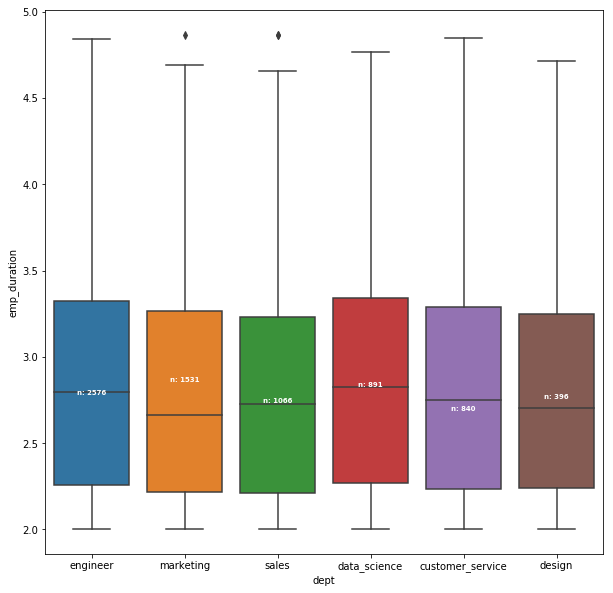

In [82]:
plt.figure(figsize=(10, 10))

ax = sns.boxplot(x="dept", y="emp_duration", data=perm)
 
# Calculate number of obs per group & median to position labels
medians = perm.groupby(['dept'])['emp_duration'].median().values
nobs = perm['dept'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
    horizontalalignment='center', size='x-small', color='w', weight='semibold')

The average employment duration is similar across the departments.

In [73]:
work = work[work.seniority != 98] # delete row with 98 seniority value

In [75]:
work = work[work.seniority != 99] # delete row with 99 seniority value

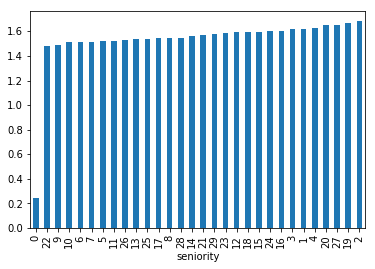

In [79]:
work.groupby('seniority')['emp_duration'].mean().sort_values(ascending=True).plot(kind='bar') 

There doesn't look to be a strong connection between years of seniority and employment duration among these employees, except that those hired with no experience are employed for a very short time on average (a couple of months). 

In [80]:
corr = perm.corr() # correlation matrix for all variables except department; ignore company id
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,company_id,seniority,salary,emp_duration
company_id,1,-0.016,-0.18,0.0055
seniority,-0.016,1,0.61,0.0083
salary,-0.18,0.61,1,0.039
emp_duration,0.0055,0.0083,0.039,1


In terms of correlations across all the employee records, it appears that:

- salaries are notably correlated with number of years of work experience when hired (not surprising); and
- there is only a very low correlation for employment duration with seniority and with salary.

I'll look at one more item -- whether there is anything obvious about _when_ people were hired and whether they stuck around for 2+ years.

In [83]:
perm.set_index(['join_date_clean'],inplace=True)

In [84]:
perm.head()

,company_id,dept,seniority,salary,quit_date_clean,emp_duration
join_date_clean,,,,,,
2012-01-17,2,engineer,19,309000.0,NaT,3.9042
2012-03-05,3,engineer,24,265000.0,NaT,3.7728
2012-10-01,1,marketing,8,117000.0,NaT,3.1978
2011-05-31,1,sales,15,241000.0,2014-03-28,2.8255
2013-06-24,5,data_science,26,240000.0,NaT,2.4695


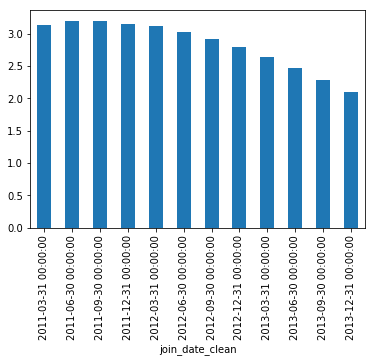

In [90]:
perm['emp_duration'].resample('Q').mean().plot(kind='bar')

Looking at the data by quarterly periods, it seems that people hired in 2011 and into the first quarter of 2012 achieved higher mean employment duration than those hired later. Perhaps there was a change in the company during that time that affected employees' willingness to stay.

## Model Construction

Finally, because the client wishes to be able to predict churn, I will construct a model for this purpose. In order to quickly and easily incorporate all the available data, I will use a random forest model. I will include all permanent employees, not just those with 2+ years employment, but I will add an indicator feature for those who make it to 2+ years. This can be my target feature for prediction.

In [171]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [155]:
perm_all = work[(work.dept != 'temp_contractor')] 

In [156]:
perm_all['indicator'] = ''

/Users/ssivek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [157]:
perm_all.loc[perm_all['emp_duration'] >= 2, 'indicator'] = 1
perm_all.loc[perm_all['emp_duration'] < 2, 'indicator'] = 0

/Users/ssivek/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [158]:
perm_all['indicator'] = perm_all['indicator'].astype(int)

/Users/ssivek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [159]:
perm_all.indicator.value_counts()

0    17163
1     7298
Name: indicator, dtype: int64

In [161]:
dummies = pd.get_dummies(perm_all.dept, drop_first=True) # dummy encoding for departments

In [162]:
perm_all = perm_all.join(dummies) 

In [163]:
perm_all.head()

,company_id,dept,seniority,salary,join_date_clean,quit_date_clean,emp_duration,indicator,data_science,design,engineer,marketing,sales
1,8,design,21,191000.0,2011-05-17,2012-03-16,0.8323,0,0,1,0,0,0
7,7,data_science,7,140000.0,2011-12-27,2013-08-30,1.6756,0,1,0,0,0,0
8,10,data_science,16,238000.0,2013-12-23,NaT,1.9713,0,1,0,0,0,0
23,1,sales,19,179000.0,2011-09-19,2012-11-02,1.1225,0,0,0,0,0,1
34,2,engineer,19,309000.0,2012-01-17,NaT,3.9042,1,0,0,1,0,0


## Random Forest

In [206]:
from sklearn.ensemble import RandomForestClassifier # import necessary stuff

In [207]:
rf = perm_all

In [208]:
rf.columns

Index(['company_id', 'dept', 'seniority', 'salary', 'join_date_clean',
       'quit_date_clean', 'emp_duration', 'indicator', 'data_science',
       'design', 'engineer', 'marketing', 'sales'],
      dtype='object')

In [209]:
# define features and target for model
features = ['seniority', 'salary', 'data_science', 'design', 'engineer',
       'marketing', 'sales'] # features for model
X = rf[features]
y = rf.indicator # target

In [210]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) # 80% training and 20% test

In [216]:
#Create a Gaussian Classifier
rand_for = RandomForestClassifier(n_estimators=100, class_weight='balanced')

#Train the model using the training sets 
rand_for.fit(X_train,y_train)

y_pred = rand_for.predict(X_test)

In [217]:
def display_scores(rand_for): # use k-fold cross-validation to assess model, 10 folds
        acc = cross_val_score(rand_for, X, y, cv=5, scoring='accuracy').mean()
        prec = cross_val_score(rand_for, X, y, cv=5, scoring='precision').mean()
        rec = cross_val_score(rand_for, X, y, cv=5, scoring='recall').mean()
        print("5-fold cross validation scores:")
        print("Mean accuracy {}".format(acc))
        print("Mean precision {}".format(prec))
        print("Mean recall {}".format(rec))

In [218]:
display_scores(rand_for)

5-fold cross validation scores:
Mean accuracy 0.5716871075779397
Mean precision 0.30852221825172504
Mean recall 0.34722112161641955


In [219]:
importances = rand_for.feature_importances_
std = np.std([tree.feature_importances_ for tree in rand_for.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 1 (0.787062)
2. feature 0 (0.202740)
3. feature 6 (0.002336)
4. feature 2 (0.002268)
5. feature 4 (0.002260)
6. feature 5 (0.001708)
7. feature 3 (0.001626)


According to this ranking, the two most important features in predicting whether an employee stays 2+ years are: 1) salary and 2) seniority, followed by the various department dummy features at much lower levels of importance. Of course, salary and seniority were fairly highly correlated already (0.61).

This model is not performing very well at all. While my model building could certainly use more time here, I think that -- given my findings during the exploration above -- the information provided is likely not capturing the important factors that affect employee churn among permanent employees. Salary appears to be correlated to seniority (experience at the time of hiring), but not to duration of employment, and seniority doesn't correlate with duration either. 

## Summary and Next Steps

Given the likely limitations of the data provided as stated above, here are the most significant findings from this analysis:

- seniority and salary are not strongly correlated to duration of employment
- department does not appear to be strongly related either
- employees hired earlier among those included in these data had a greater likelihood of making it to 2+ years of employment

For next steps, I would suggest:

- Attempt other models (K nearest neighbors or a decision tree?).
- Gather additional data to add greater explanatory power (for example, age of employee at hire, gender, amount of training, performance review scores, type of position -- managerial, clerical, etc. -- and so forth).

## JUST EXPERIMENTING MORE HERE, WAY OUT OF TIME

## K Nearest Neighbors

In [262]:
from sklearn.neighbors import KNeighborsClassifier

kn = perm_all

# define features and target for model
features = ['seniority', 'salary', 'data_science', 'design', 'engineer',
       'marketing', 'sales'] # features for model
X = kn[features]
y = kn.indicator # target

In [248]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) # 80% training and 20% test

In [256]:
kn_model = KNeighborsClassifier(n_neighbors=7)

# Train the model using the training sets
kn_model.fit(X_train,y_train)

y_pred = kn_model.predict(X_test)

In [271]:
def display_scores(kn_model): # use k-fold cross-validation to assess model, 5 folds
        acc = cross_val_score(kn_model, X, y, cv=5, scoring='accuracy').mean()
        prec = cross_val_score(kn_model, X, y, cv=5, scoring='precision').mean()
        rec = cross_val_score(kn_model, X, y, cv=5, scoring='recall').mean()
        print("5-fold cross validation scores:")
        print("Mean accuracy {}".format(acc))
        print("Mean precision {}".format(prec))
        print("Mean recall {}".format(rec))

In [272]:
display_scores(kn_model)

5-fold cross validation scores:
Mean accuracy 0.6545937238043174
Mean precision 0.32429511279336054
Mean recall 0.14538321424882872


## Decision Tree Classifier

In [267]:
from sklearn.tree import DecisionTreeClassifier # import decision tree classifier

In [266]:
dt_df = perm_all

In [341]:
# define features and target for model
features = ['seniority', 'salary', 'data_science', 'design', 'engineer', 'marketing', 'sales'] # features for model
X = dt_df[features]
y = dt_df.indicator # target

In [342]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) # 80% training and 20% test

In [343]:
# create decision tree classifier
# I have tinkered with different max_depth, splitter, and min_samples_split parameter values to improve metrics
dec_tree = DecisionTreeClassifier(criterion="gini", max_depth=None, splitter="best", min_samples_split=50,
                                 class_weight="balanced")

dec_tree = dec_tree.fit(X_train,y_train) # train classifier

y_pred = dec_tree.predict(X_test) # generate predictions

In [344]:
def display_scores(dec_tree): # use k-fold cross-validation to assess model, 5 folds
        acc = cross_val_score(dec_tree, X, y, cv=5, scoring='accuracy').mean()
        prec = cross_val_score(dec_tree, X, y, cv=5, scoring='precision').mean()
        rec = cross_val_score(dec_tree, X, y, cv=5, scoring='recall').mean()
        print("5-fold cross validation scores:")
        print("Mean accuracy {}".format(acc))
        print("Mean precision {}".format(prec))
        print("Mean recall {}".format(rec))

In [345]:
display_scores(dec_tree)

#5-fold cross validation scores: (best with all features)
#Mean accuracy 0.5212794029399461
#Mean precision 0.3118802080319974
#Mean recall 0.5009588102190466

5-fold cross validation scores:
Mean accuracy 0.5212384279354093
Mean precision 0.31178743127233216
Mean recall 0.5009588102190466


In [346]:
dec_tree.feature_importances_

array([0.30881385, 0.57465213, 0.02301984, 0.02021055, 0.01880975,
       0.02548147, 0.0290124 ])